**Machine Learning for Time Series (Master MVA)**

- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this tutorial, we illustrate the following concepts:

- feature extraction on time series
- feature selection

## Setup

**Imports**

In [1]:
from itertools import tee

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loadmydata.load_uea_ucr import load_uea_ucr_data
from numpy.fft import rfft, rfftfreq
from scipy.cluster import hierarchy
from scipy.signal import argrelmax, stft
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway, spearmanr
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from statsmodels.tsa.stattools import acf

**Utility functions**

In [2]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [3]:
def get_largest_local_max(signal1D: np.ndarray, order: int = 1):
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_index = all_local_max_indexes[all_local_max.argsort()[-1]]

    return signal1D[largest_local_max_index], largest_local_max_index

In [4]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

## Data

In [5]:
# fmt: off
X_train = np.loadtxt("BinaryHeartbeat.csv").reshape((204, 18530, 1))
y_train = np.array(['Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal'])
# fmt: on

# Sampling frequency
FREQUENCY = 2000  # Hz

Choose a signal from the data set.

In [6]:
ind = 3
signal = X_train[ind].flatten()
label = y_train[ind]
n_samples = signal.shape[0]
print(label)

Abnormal


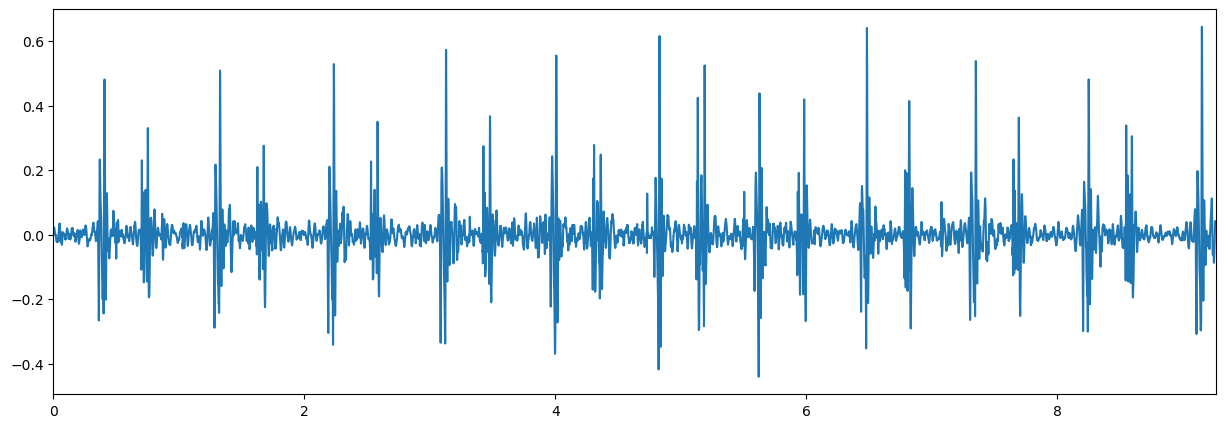

In [7]:
fig, ax = fig_ax()
tt = np.arange(n_samples) / FREQUENCY
ax.plot(tt, signal)
_ = ax.set_xlim(0, n_samples / FREQUENCY)

Compute the spectrogram


In [8]:
f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=1000, noverlap=800)

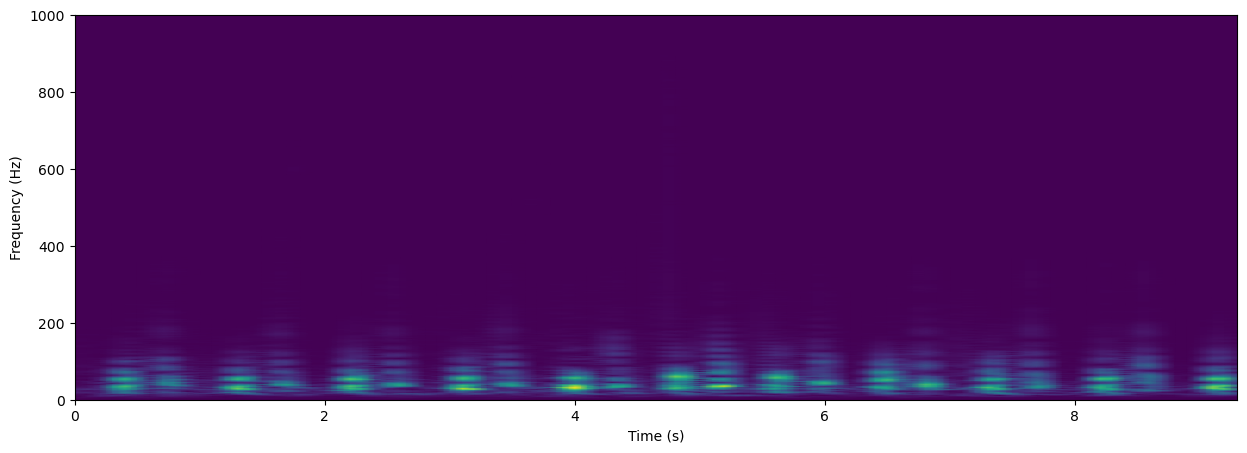

In [9]:
fig, ax = fig_ax()
ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Replot the same spectrogram as above, but zoom on the interesting frequencies (set <tt>cut_off_freq</tt> in the following cell).</p>
    <ul>
        <li>What are the repeated patterns? What is the frequency of interest (approximately)?</li>
        <li>What happens when you increase the number of samples per windows?</li>
        <li>What happens when you increase the overlap between windows?</li>
    </ul>
</div>

When overlap increases, the resolution increases.
When length of frame increases, the resolution increases.


In [10]:
# Cut-off frequency
cut_off_freq = 200  # Hz

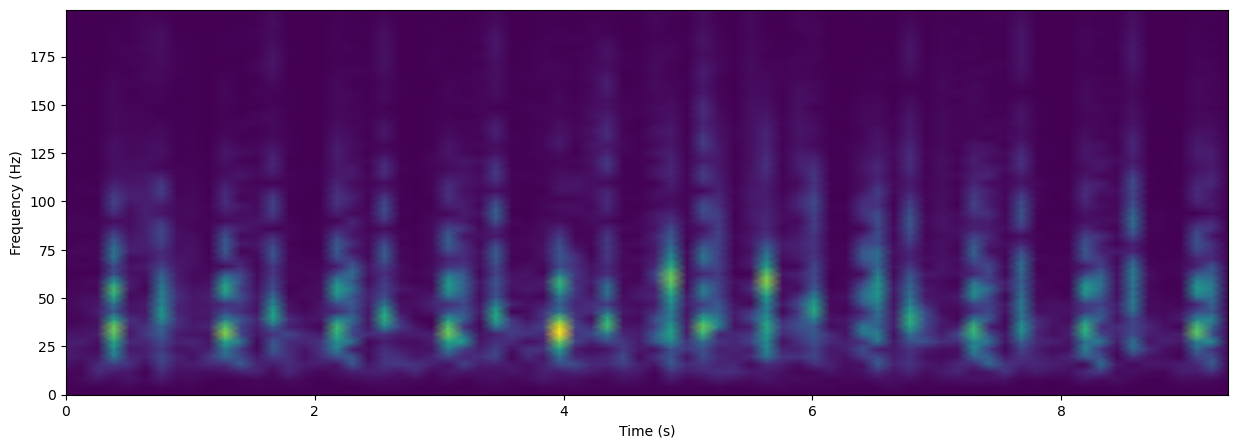

In [11]:
fig, ax = fig_ax()

f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=512, noverlap=256)

keep_mask = f < cut_off_freq

ax.pcolormesh(
    t, f[keep_mask], np.abs(Zxx[keep_mask]), vmin=0, shading="gouraud"
)
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

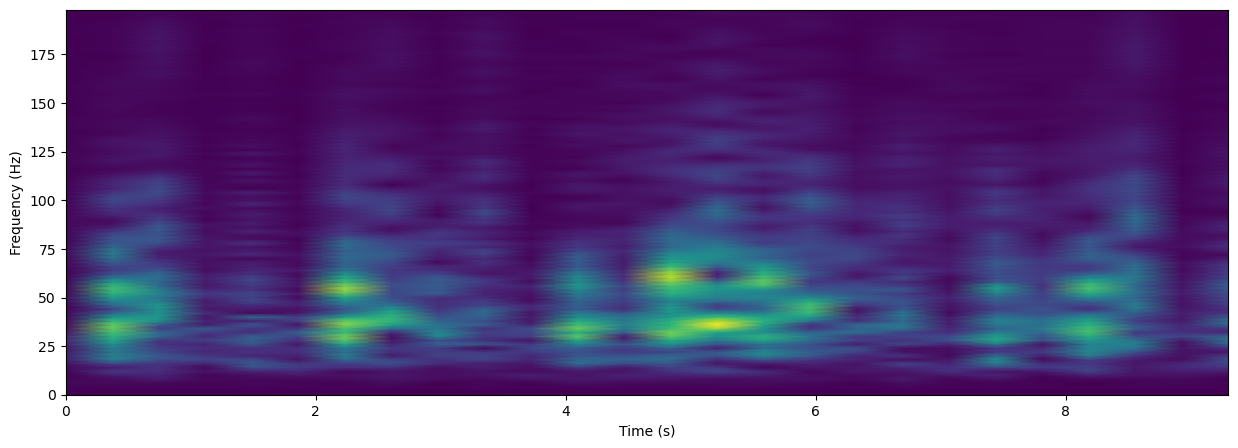

In [12]:
fig, ax = fig_ax()

f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=1000, noverlap=256)

keep_mask = f < cut_off_freq

ax.pcolormesh(
    t, f[keep_mask], np.abs(Zxx[keep_mask]), vmin=0, shading="gouraud"
)
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

# Feature extraction

## Statistical features

### Moments and percentiles

In [13]:
def get_distribution_features(signal: np.ndarray) -> dict:
    res_dict = dict()
    res_dict["mean"] = signal.mean()
    res_dict["std"] = signal.std()
    res_dict["min"] = signal.min()
    res_dict["max"] = signal.max()
    return res_dict

In [14]:
get_distribution_features(signal)

{'mean': -2.6195999439287612e-05,
 'std': 0.07553291087476237,
 'min': -0.4403687,
 'max': 0.6446533}

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Rewrite in the following cell, the function <tt>get_distribution_features(signal)->dict</tt> so that is also computes the kurtosis, the skew (available in the <tt>scipy.stats</tt> module) and the 25%, 50% and 75% percentiles.</p>
</div>

In [15]:
from scipy.stats import kurtosis,skew
def get_distribution_features(signal: np.ndarray) -> dict:
    res_dict = dict()
    res_dict["mean"] = signal.mean()
    res_dict["std"] = signal.std()
    res_dict["min"] = signal.min()
    res_dict["max"] = signal.max()
    res_dict["kurtosis"]=kurtosis(signal)
    res_dict['skew']=skew(signal)
    res_dict["25 per"] = np.percentile(signal, 25)
    res_dict["50 per"] = np.percentile(signal, 50)
    res_dict["75 per"] = np.percentile(signal, 75)
    return res_dict



In [16]:
get_distribution_features(signal)

{'mean': -2.6195999439287612e-05,
 'std': 0.07553291087476237,
 'min': -0.4403687,
 'max': 0.6446533,
 'kurtosis': 15.069250155393355,
 'skew': 1.424710311802977,
 '25 per': -0.0200119,
 '50 per': -0.0002746582,
 '75 per': 0.01864624}

### Autocorrelation

For a signal $x\in\mathbb{R}^N$ with $N$ samples, the autocorrelation with lag $m$ is defined as follows:

$$
\hat{\gamma}[m] := \frac{1}{N-|m|} \sum_{n=0}^{N -|m|-1} x[n]x[n+m].
$$

Note that if the signal $x$ is periodic, then the autocorrelation is also periodic with same period.

Let us plot the autocorrelation of a sound signal.

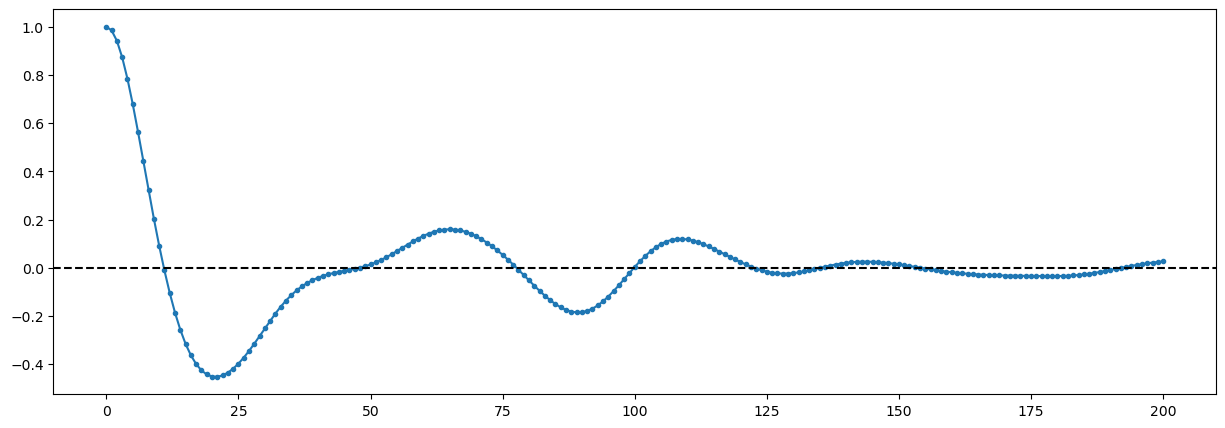

In [17]:
fig, ax = fig_ax()
ax.plot(acf(signal, nlags=200, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>We would like to also compute the maximum autocorrelation value and the associated lag in Hz (a local maximum that is not 0). Explain how you can convert a lag expressed in number of samples to a lag expressed in Hz.</p>
</div>

Compute the autocorrelation features.

In [18]:
def get_autocorr_features(signal: np.ndarray, n_lags: int = 200) -> dict:
    auto_corr = acf(signal, nlags=n_lags, fft=True)
    res_dict = dict()
    for lag, auto_corr_value in enumerate(auto_corr):
        res_dict[f"autocorrelation_{lag}_lag"] = auto_corr_value
    
    local_argmax, local_max = get_largest_local_max(auto_corr,order=10)
    res_dict["lag_max_autocorrelation_Hz"] = FREQUENCY / local_argmax
    res_dict["max_autocorrelation"] = local_max

    return res_dict

In [19]:
get_autocorr_features(signal, n_lags=100)

{'autocorrelation_0_lag': 1.0,
 'autocorrelation_1_lag': 0.985005586460975,
 'autocorrelation_2_lag': 0.9418538165034437,
 'autocorrelation_3_lag': 0.8735145181165256,
 'autocorrelation_4_lag': 0.7843181525984162,
 'autocorrelation_5_lag': 0.6794504024816174,
 'autocorrelation_6_lag': 0.5641022384259387,
 'autocorrelation_7_lag': 0.44344874752906,
 'autocorrelation_8_lag': 0.3220887917407827,
 'autocorrelation_9_lag': 0.20399375875559503,
 'autocorrelation_10_lag': 0.09223255876203246,
 'autocorrelation_11_lag': -0.010920557907652546,
 'autocorrelation_12_lag': -0.10398259052847027,
 'autocorrelation_13_lag': -0.18601400454582545,
 'autocorrelation_14_lag': -0.25651754896050666,
 'autocorrelation_15_lag': -0.3153688531580506,
 'autocorrelation_16_lag': -0.3627484644649048,
 'autocorrelation_17_lag': -0.39917126937165287,
 'autocorrelation_18_lag': -0.4253873352745865,
 'autocorrelation_19_lag': -0.44231002862903346,
 'autocorrelation_20_lag': -0.4508615574945478,
 'autocorrelation_21_l

## Spectral features

Plot the Fourier coefficients of a signal (y=absolute value, x=frequency) using `rfft()` and `rfftfreq()`.

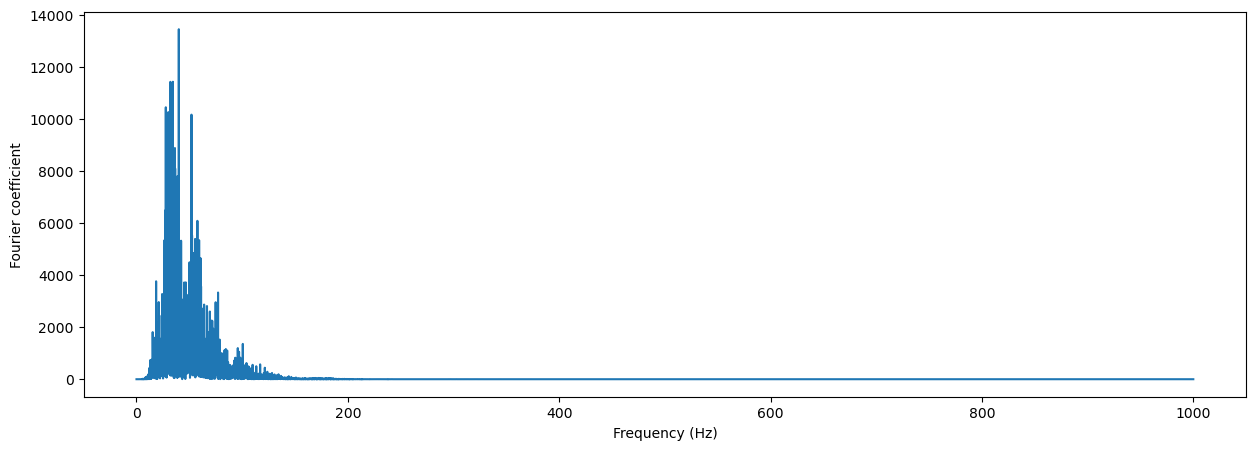

In [20]:
fourier = abs(rfft(signal)) ** 2
freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)

fig, ax = fig_ax()
ax.plot(freqs, fourier)
ax.set_xlabel("Frequency (Hz)")
_ = ax.set_ylabel("Fourier coefficient")

Compute the spectral features.

In [21]:
def get_fourier_features(signal: np.ndarray, n_bins: int = 100) -> dict:
    """The signal is assumed to be centered and scaled to unit variance."""
    n_samples = signal.shape[0]
    fourier = abs(rfft(signal))
    freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)
    res_dict = dict()

    freq_bins = np.linspace(0, FREQUENCY / 2, n_bins + 1)
    for f_min, f_max in pairwise(freq_bins):
        keep = (f_min <= freqs) & (freqs < f_max)
        res_dict[f"fourier_{f_min:.0f}-{f_max:.0f}_Hz"] = np.log(
            np.sum(fourier[keep] ** 2)
        )
    return res_dict

In [22]:
get_fourier_features(signal, n_bins=10)

{'fourier_0-100_Hz': 13.751949923930825,
 'fourier_100-200_Hz': 10.59747282288769,
 'fourier_200-300_Hz': 6.537365606662959,
 'fourier_300-400_Hz': 5.147798446884277,
 'fourier_400-500_Hz': 3.759072313502295,
 'fourier_500-600_Hz': 3.346913840643639,
 'fourier_600-700_Hz': 3.2588202190287703,
 'fourier_700-800_Hz': 3.2962829753016507,
 'fourier_800-900_Hz': 3.1800188224922636,
 'fourier_900-1000_Hz': 2.5962961978666015}

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>The frequency features are not scaled. If the signal is normalized, do we need to?</p>
</div>

We don't need to scale the frequency features because according to perceval equality the signal norm is equal to the norm of its fourier transform.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> We have used regularly spaced frequency bins. What would be a better approach? </p>

</div>

We can choose a grid where we select many frequency points in the area of interest and out of this area we can choose wide bins like what 's done in mfcc

## Concatenate all features

In the following cell, we write a function `get_features(signal: np.ndarray) -> dict` that computes all features from above.

In [23]:
def get_features(signal: np.ndarray) -> dict:
    res_dict = dict()

    # stats
    res_dict.update(get_distribution_features(signal))

    # spectral
    signal -= signal.mean()
    signal /= signal.std()
    res_dict.update(get_fourier_features(signal, n_bins=50))

    # autocorrelation
    res_dict.update(get_autocorr_features(signal, n_lags=200))

    return res_dict

In [24]:
get_features(signal)

{'mean': -2.6195999439287612e-05,
 'std': 0.07553291087476237,
 'min': -0.4403687,
 'max': 0.6446533,
 'kurtosis': 15.069250155393355,
 'skew': 1.424710311802977,
 '25 per': -0.0200119,
 '50 per': -0.0002746582,
 '75 per': 0.01864624,
 'fourier_0-20_Hz': 15.773631211188754,
 'fourier_20-40_Hz': 18.058406494660073,
 'fourier_40-60_Hz': 17.828232535139936,
 'fourier_60-80_Hz': 16.99776774880173,
 'fourier_80-100_Hz': 15.942609434276333,
 'fourier_100-120_Hz': 15.261741988187408,
 'fourier_120-140_Hz': 14.365400852373103,
 'fourier_140-160_Hz': 13.138115802537095,
 'fourier_160-180_Hz': 12.73853392472489,
 'fourier_180-200_Hz': 12.145773818342,
 'fourier_200-220_Hz': 10.940269137414845,
 'fourier_220-240_Hz': 10.282190588673782,
 'fourier_240-260_Hz': 9.57824311129101,
 'fourier_260-280_Hz': 9.164408218258423,
 'fourier_280-300_Hz': 9.342684848263948,
 'fourier_300-320_Hz': 9.259355747712691,
 'fourier_320-340_Hz': 9.096731570906437,
 'fourier_340-360_Hz': 8.599592585569129,
 'fourier_360

Compute all features over the data set.

In [25]:
all_features = pd.DataFrame(
    [get_features(signal.flatten()) for signal in X_train]
)

In [26]:
all_features.head()

,mean,std,min,max,kurtosis,skew,25 per,50 per,75 per,fourier_0-20_Hz,...,autocorrelation_193_lag,autocorrelation_194_lag,autocorrelation_195_lag,autocorrelation_196_lag,autocorrelation_197_lag,autocorrelation_198_lag,autocorrelation_199_lag,autocorrelation_200_lag,lag_max_autocorrelation_Hz,max_autocorrelation
0,-0.000044,0.053476,-0.325073,0.291504,4.395775,0.286963,-0.027130,-0.000610,0.025116,17.425511,...,-0.013568,-0.010462,-0.007693,-0.005201,-0.002915,-0.000772,0.001283,0.003267,14634.535199,100
1,-0.000026,0.021232,-0.109467,0.139496,4.207598,0.389185,-0.011505,-0.000244,0.010864,17.947738,...,0.147982,0.143621,0.139093,0.134445,0.129681,0.124822,0.119951,0.115106,11806.567601,184
2,-0.000069,0.034245,-0.253387,0.291596,22.093219,1.362185,-0.007721,-0.000031,0.007477,15.761979,...,0.007707,0.006197,0.004491,0.002655,0.000759,-0.001193,-0.003117,-0.005015,17684.758158,49
3,-0.000026,0.075533,-0.440369,0.644653,15.069250,1.424710,-0.020012,-0.000275,0.018646,15.773631,...,0.003933,0.008041,0.011920,0.015518,0.018804,0.021765,0.024399,0.026711,12505.062986,65
4,-0.000021,0.126608,-1.000000,0.999969,20.218365,0.238795,-0.017639,0.000275,0.016685,15.738893,...,0.025114,0.024158,0.023134,0.022036,0.020845,0.019556,0.018152,0.016617,7066.847688,54


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> How many features do we have in the end?</p>
</div>

In [27]:
all_features.shape

(204, 262)

# Feature selection

## Unsupervised selection

### Sanity checks

#### Low variance threshold

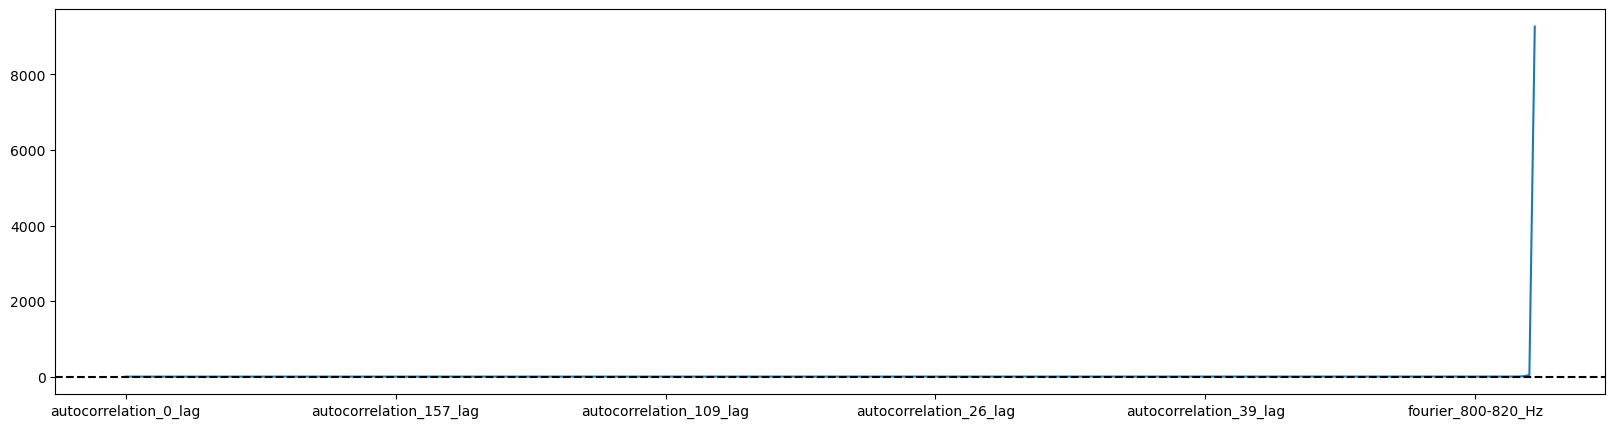

In [28]:
fig, ax = fig_ax(figsize=(20, 5))
all_features.std().sort_values().plot(ax=ax)

# change the height of the horizontal line here
ax.axhline(0.01, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Choose a variance threshold (name it <tt>variance_threshold</tt>).</p>
</div>

In [29]:
variance_threshold = 0.04

Be careful when dropping low variance features, they might still be informative. Quickly check that it makes sense to drop them.

In [30]:
low_variance_features = all_features.std() < variance_threshold
low_variance_features = low_variance_features[
    low_variance_features
].index.to_numpy()
print(f"There are {len(low_variance_features)} features to drop.")
print(low_variance_features)

There are 5 features to drop.
['mean' '25 per' '50 per' '75 per' 'autocorrelation_0_lag']


The following cell drops the low-variance features. Only execute it when you are sure of the features you want to remove.

In [31]:
all_features.drop(columns=low_variance_features, inplace=True, errors="ignore")
print(f"There are {all_features.shape[1]} features left.")

There are 257 features left.


#### Check outliers

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> One feature has larger variations than the others: which one is it? (Name it <tt>feature_to_check</tt>.) Show the associated boxplot.</p>
</div>

In [32]:
feature_to_check = "lag_max_autocorrelation_Hz"


In [33]:
all_features[feature_to_check].argmax(),all_features[feature_to_check][179]

(64, 9145.175265561214)

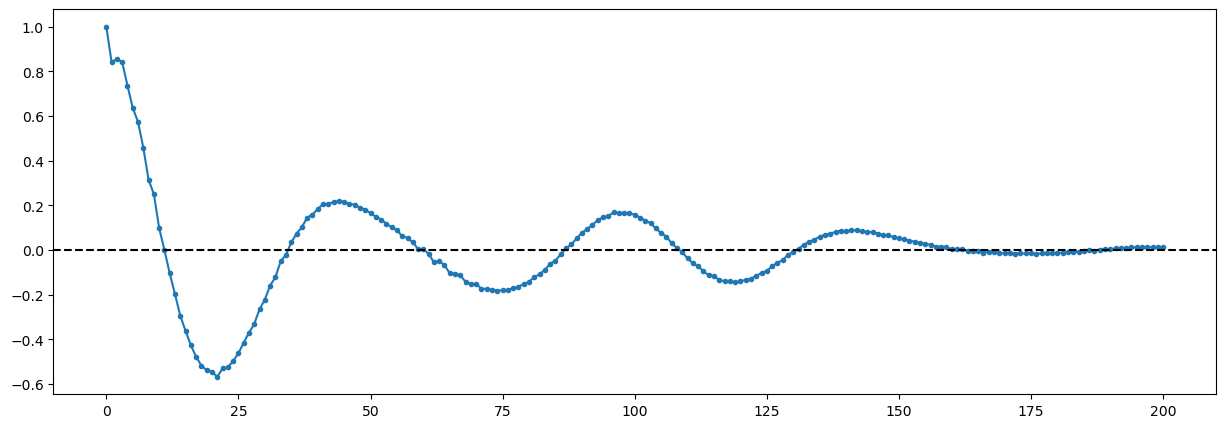

In [34]:
signal = X_train[179]
fig, ax = fig_ax()
ax.plot(acf(signal, nlags=200, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Check the outliers. Is there something we can do to remediate this issue?</p>
</div>

### Multicollinearity

Multicollinearity degrades numerical stability and interpretability.
Compute the correlation.
Features with a correlation above a threshold are grouped together in a cluster.
We then choose a single feature from each cluster.

In [35]:
correlation_threshold = 0.8

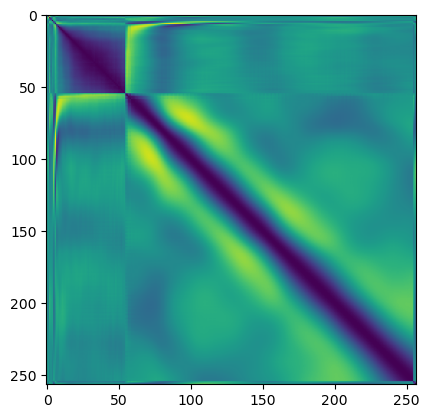

In [36]:
corr = pdist(all_features.to_numpy().T, metric="correlation")  # distance matrix
plt.imshow(squareform(corr))

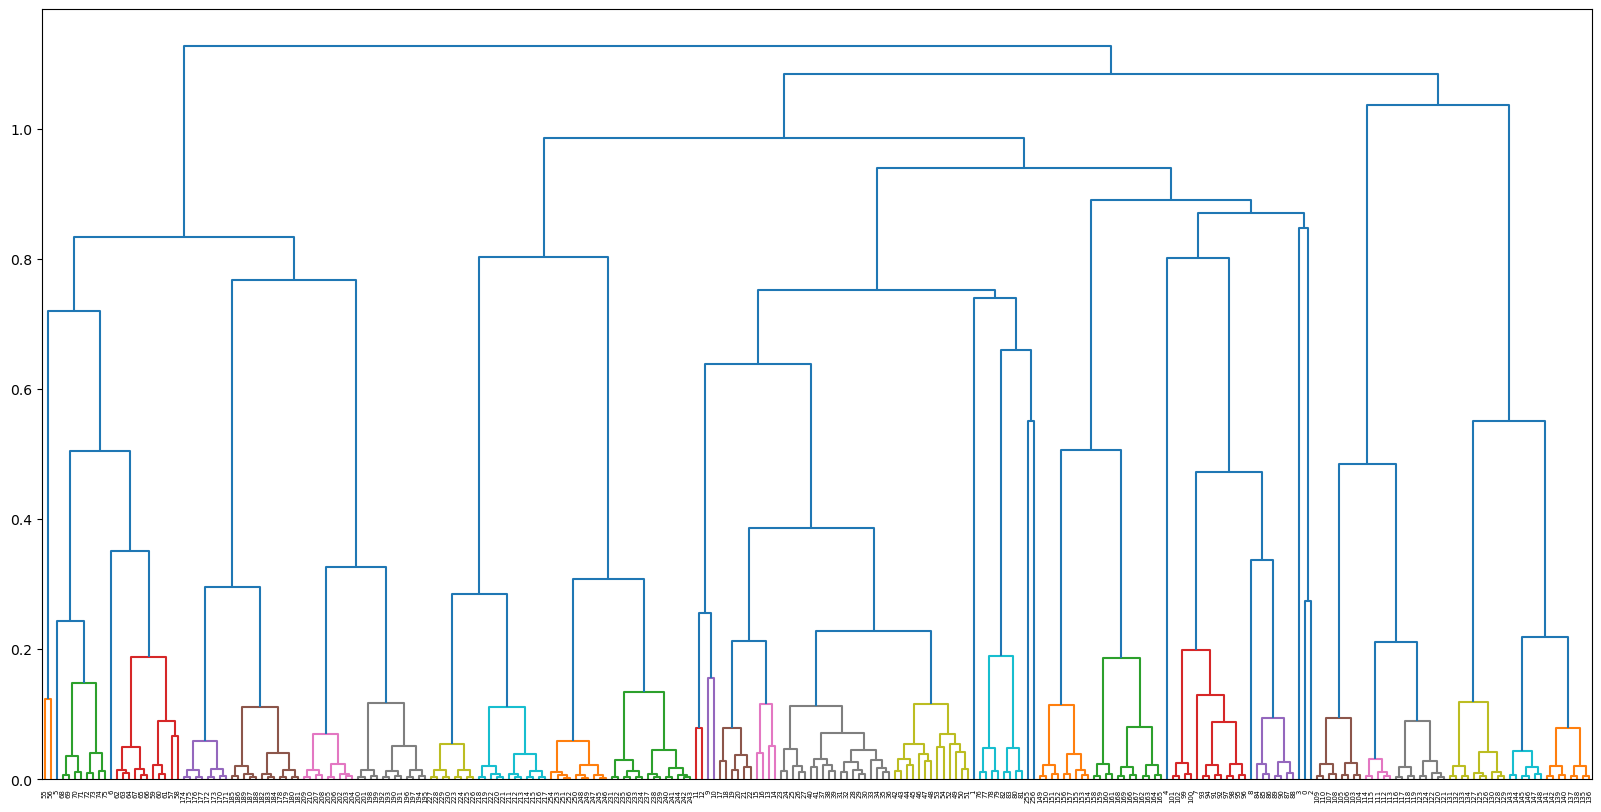

In [37]:
fig, ax = fig_ax((20, 10))
corr_linkage = hierarchy.average(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax, color_threshold=1 - correlation_threshold
)

In [38]:
# compute the clusters
cluster_ids = hierarchy.fcluster(
    corr_linkage, 1 - correlation_threshold, criterion="distance"
)

# print the largest clusters
largest_cluster_ind = np.bincount(cluster_ids).argmax()
print(
    f"The largest cluster is {all_features.columns[cluster_ids==largest_cluster_ind].tolist()}."
)

# for each cluster, only keep the first feature
keep_features = list()
for cluster in np.unique(cluster_ids):
    cluster_indexes = np.where(cluster_ids == cluster)[0]
    keep_features.append(all_features.columns[cluster_indexes[0]])

The largest cluster is ['fourier_360-380_Hz', 'fourier_380-400_Hz', 'fourier_400-420_Hz', 'fourier_420-440_Hz', 'fourier_440-460_Hz', 'fourier_460-480_Hz', 'fourier_480-500_Hz', 'fourier_500-520_Hz', 'fourier_520-540_Hz', 'fourier_540-560_Hz', 'fourier_560-580_Hz', 'fourier_580-600_Hz', 'fourier_600-620_Hz', 'fourier_620-640_Hz', 'fourier_640-660_Hz', 'fourier_660-680_Hz', 'fourier_680-700_Hz', 'fourier_700-720_Hz', 'fourier_720-740_Hz'].


In [39]:
# Reduce the number of features
all_features = all_features[keep_features]

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> How many features do we have in the end?</p>
</div>

In [40]:
all_features.shape

(204, 38)

### PCA

In [41]:
all_features_centered = all_features.to_numpy()

all_features_centered -= all_features_centered.mean(axis=0)
all_features_centered /= all_features_centered.std(axis=0)


pca = PCA(n_components=2).fit(all_features_centered)

In [42]:
pca = PCA(n_components=2).fit(all_features)

In [43]:
# select the 5 most important features (with highest norm).
top_features_for_pca = np.linalg.norm(pca.components_, axis=0).argsort()[-5:]

for feature_ind in top_features_for_pca:
    msg = f"{all_features.columns[feature_ind]}: {(pca.components_.T[feature_ind]**2).sum():.3f}"
    print(msg)

fourier_80-100_Hz: 0.000
fourier_0-20_Hz: 0.000
kurtosis: 0.004
max_autocorrelation: 0.996
lag_max_autocorrelation_Hz: 1.000


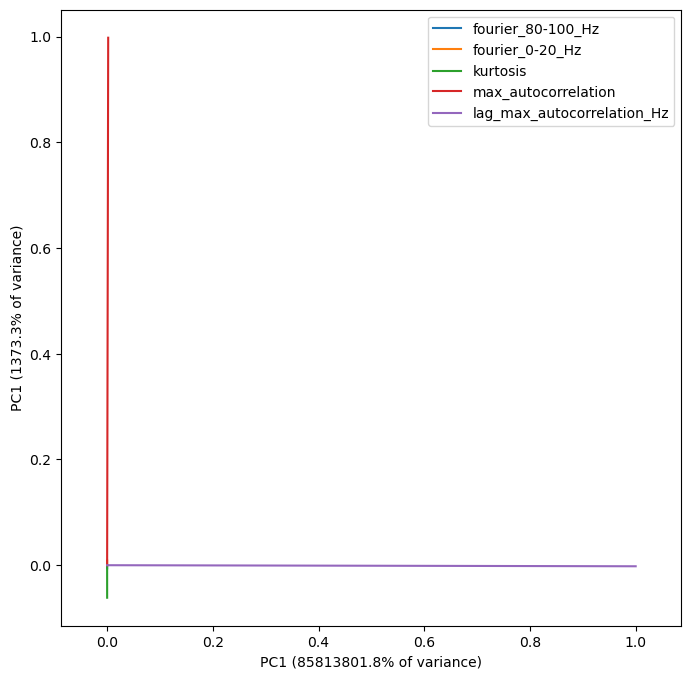

In [44]:
# plot the 2D projection of the top 5 features
fig, ax = fig_ax(figsize=(8, 8))
ax.axis("equal")
for feature_ind in top_features_for_pca:  # normaliser par la variance
    dx, dy = pca.components_.T[feature_ind]
    ax.plot([0, dx], [0, dy], label=all_features.columns[feature_ind])
ax.set_xlabel(f"PC1 ({pca.explained_variance_[0]:.1f}% of variance)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_[1]:.1f}% of variance)")
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Normalize all features to unit variance and redo the PCA.</p>
</div>

## Supervised selection

Three main classes of methods:

- **Filter methods.** We test the adequacy of the feature with the annotations, thanks to several criterion/scores (e.g. correlation).
- **Wrapper methods.** We test the features on a supervised classification task, by trying several combinations. The best features are kept.
- **Embedded methods.** Mixed approaches where we jointly infer the relevance of the features and classify the data (decision tree, sparse methods...)


### Filter methods

If a feature is highly correlated with a label, it can help achieve good classification performance.

For classification tasks, ANOVA.

In [45]:
labels = y_train
statistics, pvalues = f_oneway(
    all_features[labels == "Abnormal"], all_features[labels == "Normal"]
)

In [46]:
for ind in statistics.argsort()[::-1]:
    print(f"{all_features.columns[ind]}: {statistics[ind]:.3f}")

max: 16.456
fourier_740-760_Hz: 14.957
min: 13.055
fourier_40-60_Hz: 12.309
autocorrelation_49_lag: 11.991
autocorrelation_14_lag: 11.314
autocorrelation_22_lag: 7.894
fourier_0-20_Hz: 6.644
autocorrelation_136_lag: 4.152
std: 2.934
autocorrelation_57_lag: 2.772
fourier_360-380_Hz: 2.462
fourier_60-80_Hz: 2.115
fourier_20-40_Hz: 1.938
autocorrelation_148_lag: 1.884
fourier_240-260_Hz: 1.821
fourier_80-100_Hz: 1.728
skew: 1.505
autocorrelation_124_lag: 1.199
fourier_120-140_Hz: 1.053
autocorrelation_104_lag: 0.789
autocorrelation_1_lag: 0.701
max_autocorrelation: 0.615
autocorrelation_71_lag: 0.434
autocorrelation_81_lag: 0.430
autocorrelation_95_lag: 0.396
autocorrelation_191_lag: 0.361
autocorrelation_3_lag: 0.266
autocorrelation_62_lag: 0.169
autocorrelation_177_lag: 0.102
autocorrelation_30_lag: 0.045
fourier_160-180_Hz: 0.041
autocorrelation_169_lag: 0.039
kurtosis: 0.029
autocorrelation_157_lag: 0.014
autocorrelation_116_lag: 0.011
lag_max_autocorrelation_Hz: 0.002
autocorrelation

### Wrapper methods

For a given learning algorithm, wrapper methods repeatedly select a subset of features and evaluate the selected features. Several procedures exist to select a subset but the most common are greedy and iterative; they either remove (backward selection) or add a feature (forward selection) sequentially.

In [49]:
# At each steps, SequentialFeatureSelector adds the best scoring feature to
# the set of selected features.
# For a given estimator, the score is computed with cross-validation.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)
knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(
    knn, n_features_to_select=20, cv=5, scoring=make_scorer(accuracy_score),n_jobs=1
)
sfs.fit(all_features, labels)

print("Selected features:")
print(all_features.columns[sfs.get_support()].tolist())

Selected features:
['autocorrelation_1_lag', 'autocorrelation_14_lag', 'autocorrelation_3_lag', 'autocorrelation_124_lag', 'autocorrelation_148_lag', 'autocorrelation_136_lag', 'autocorrelation_169_lag', 'autocorrelation_157_lag', 'autocorrelation_191_lag', 'autocorrelation_177_lag', 'fourier_740-760_Hz', 'autocorrelation_95_lag', 'autocorrelation_104_lag', 'autocorrelation_30_lag', 'skew', 'std', 'autocorrelation_49_lag', 'autocorrelation_57_lag', 'autocorrelation_62_lag', 'autocorrelation_89_lag']


### Embedded methods

Such methods use the intrinsic structure of a learning algorithm to embed feature selection into the underlying model.

In [50]:
rf = RandomForestClassifier().fit(all_features, labels)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Print features in descending order of importance, measured by the random forest feature importance (see the <tt>feature_importances_</tt> attribute).</p>
</div>


In [51]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': all_features.columns,
    'Importance': importances
})

# Sort features by importance in descending order
sorted_features = feature_importances.sort_values(by='Importance', ascending=False)

# Print sorted features
print("Features sorted by importance:")
print(sorted_features)

Features sorted by importance:
                       Feature  Importance
29                         std    0.068832
18          fourier_740-760_Hz    0.063325
30                         max    0.043423
21         max_autocorrelation    0.040387
25            fourier_40-60_Hz    0.034570
8      autocorrelation_136_lag    0.033541
22                         min    0.032049
1       autocorrelation_14_lag    0.031252
27            fourier_60-80_Hz    0.030588
34      autocorrelation_62_lag    0.028555
28                        skew    0.028280
19      autocorrelation_22_lag    0.028060
32      autocorrelation_49_lag    0.027265
2              fourier_0-20_Hz    0.025529
13          fourier_120-140_Hz    0.025493
7      autocorrelation_148_lag    0.024846
20  lag_max_autocorrelation_Hz    0.024457
10     autocorrelation_157_lag    0.024029
14           fourier_80-100_Hz    0.023854
9      autocorrelation_169_lag    0.022665
15          fourier_240-260_Hz    0.022316
11     autocorrelation_